# Import libraries

In [321]:
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.api as sm
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
from matplotlib import pyplot
import pandas as pd
from atomm.DataManager.main import MSDataManager
import pandas as pd

# Obtain data

In [327]:
dm = MSDataManager()

In [349]:
sym = 'MSFT'

In [350]:
dm.ReturnLatestStoredDate(sym)

Timestamp('2020-01-06 00:00:00+0000', tz='UTC')

In [359]:
p = dm.ReturnData(sym, limit=220)['Close']

In [360]:
df = pd.DataFrame(p, columns=['Close'])
df['log_ret'] = np.log(df['Close']).diff()
df['log_ret'].fillna(method='bfill', inplace=True)

# Correlogram

In [361]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.4f}\nADF: {adfuller(x)[1]:>11.4E}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.4f}\nSD: {np.sqrt(var):>16.4f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.4f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Close price undifferenced

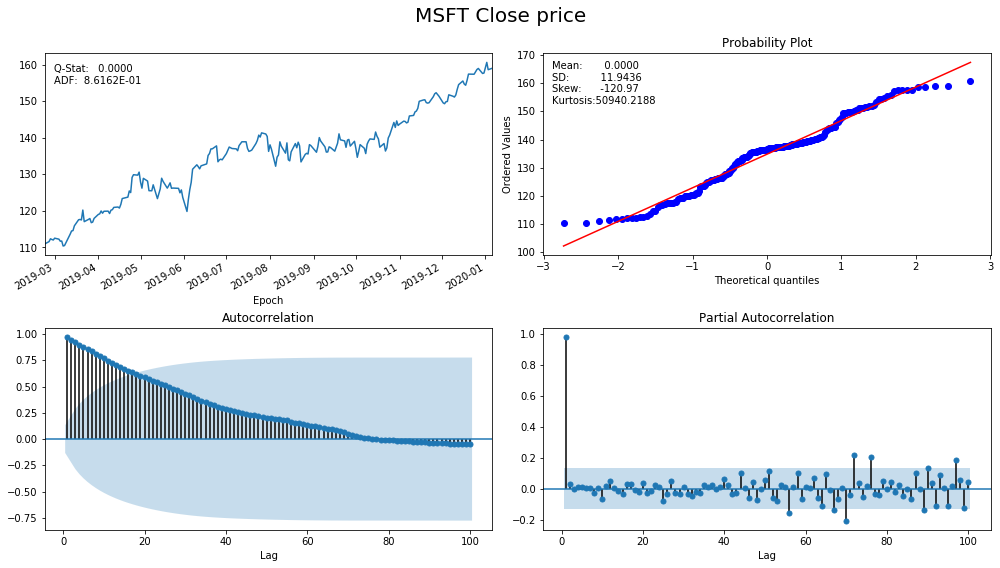

In [362]:
plot_correlogram(df['Close'], lags=100, title=f'{sym} Close price')

## Close price log diff

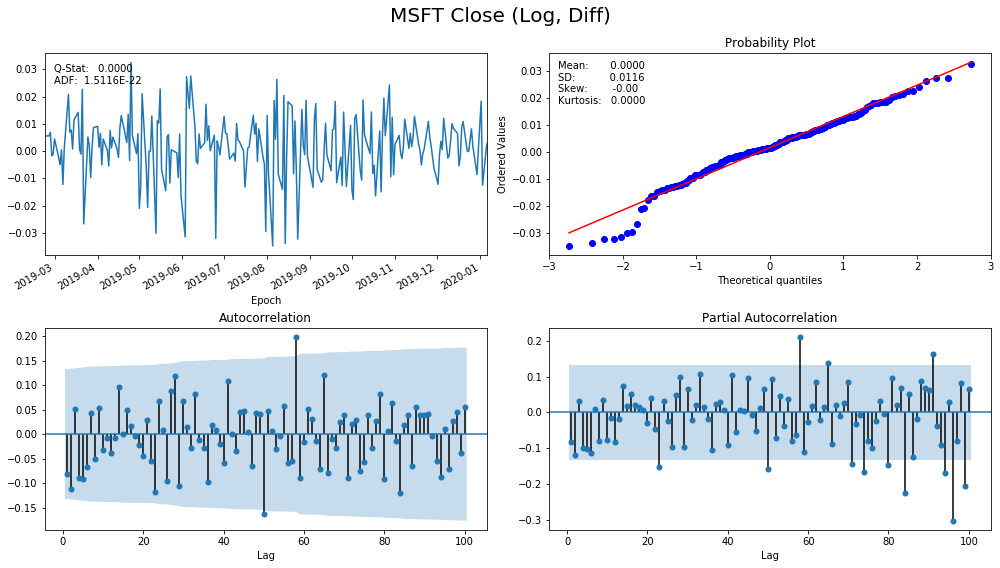

In [363]:
plot_correlogram(df['log_ret'], lags=100, title=f'{sym} Close (Log, Diff)')

# ARIMA model as feature

In [370]:
def ARIMAtrend(data, d_lookahead, d_lookback, thresh=0.01, order=(2, 1, 0)):
    preds = np.array([np.nan]*len(data))    
    for i in range(d_lookback, len(data)):
        model = ARIMA(data[:d_lookback].values, order=order)
        model_fit = model.fit(disp=0,)
        prediction = model_fit.forecast(steps=d_lookahead)
        preds[i] = prediction[0][-1]
        data = data[1:]
    return preds

In [ ]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

## Check 'log_ret' stationarity

In [365]:
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(da['log_ret'])[1])

p-value: 2.9105509283518145e-19


In [366]:
da = df.copy()

In [414]:
d_lookahead=1
d_lookback=50
sig = ARIMAtrend(da['log_ret'], d_lookahead, d_lookback, order=(3, 1, 0))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [415]:
df['arima_signal'] = sig

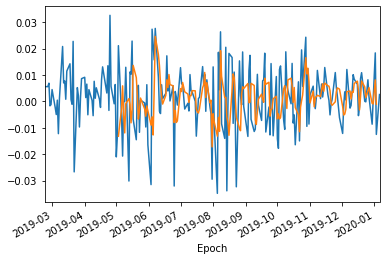

In [416]:
df['log_ret'].plot()
df['arima_signal'].shift(-1).plot()

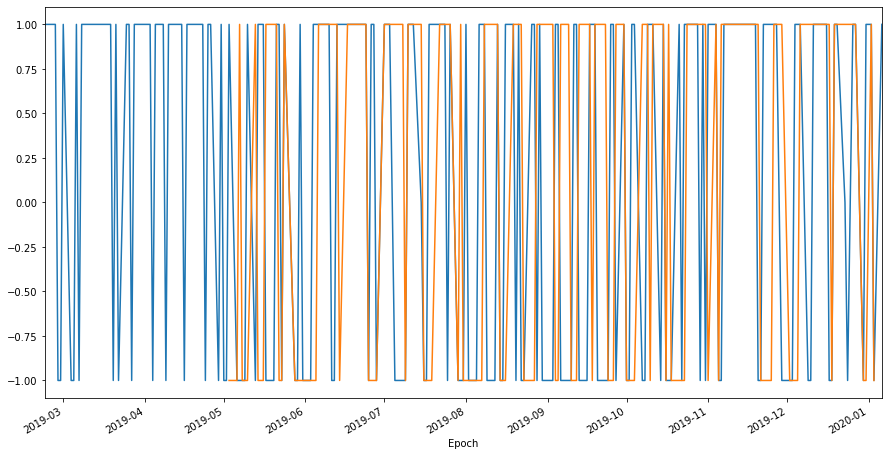

In [422]:
plt.figure(figsize=(15, 8))
df['log_ret_sign'] = np.sign(df['log_ret'])
df['log_ret_sign'].plot()
df['arima_signal_sign'] = np.sign(df['arima_signal'])
df['arima_signal_sign'].shift(-1).plot()

In [428]:
sum(df['log_ret_sign'][d_lookback:] == df['arima_signal_sign'][d_lookback:].shift(-1))

93

## Finding optimal p, d, q parameters

In [389]:
train_size = 120
test_results = {}
y_true = da['log_ret'].iloc[train_size:].values
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(da['log_ret'])):
            train_set = da['log_ret'].iloc[T-train_size:T].values
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1
            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        test_results[(p, q)] = [rmse,
                                np.mean(aic),
                                np.mean(bic),
                                convergence_error,
                                stationarity_error]

0 1


//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 2
0 3


//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 4
1 0


//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 1


NameError: name 'LinAlgError' is not defined